In [1]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [2]:

# Load dataset (assuming FER-2013 is stored in a CSV file)
data = pd.read_csv('dataset/fer2013.csv')

# Preprocess data
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

# Prepare training and test sets
def load_fer2013():
    pixels = data['pixels'].tolist()
    faces = [np.fromstring(pixel_sequence, sep=' ') for pixel_sequence in pixels]
    faces = np.asarray(faces).reshape(-1, 48, 48, 1)
    faces = preprocess_input(faces)

    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions

faces, emotions = load_fer2013()

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.2, stratify=emotions)

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 classes of emotions

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=(X_val, y_val), epochs=50)
model.save('emotion_model.h5')

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 297ms/step - accuracy: 0.2830 - loss: 1.7662 - val_accuracy: 0.4397 - val_loss: 1.4730
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 138s 306ms/step - accuracy: 0.4288 - loss: 1.4803 - val_accuracy: 0.4556 - val_loss: 1.3879
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.4719 - loss: 1.3786 - val_accuracy: 0.5007 - val_loss: 1.3091
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 305ms/step - accuracy: 0.4982 - loss: 1.3225 - val_accuracy: 0.5131 - val_loss: 1.2720
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.5143 - loss: 1.2704 - val_accuracy: 0.5294 - val_loss: 1.2464
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 306ms/step - accuracy: 0.5295 - loss: 1.2341 - val_accuracy: 0.5369 - val_loss: 1.2162
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 303ms/step - accuracy: 0.5434 - loss: 1.2005 - val_accuracy: 0.5492 - val_loss: 1.1943
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 303ms/step - accuracy: 0.5577 - loss: 1.18

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
emotion_model = load_model('emotion_model.h5')
# Make predictions on the validation set
y_pred = emotion_model.predict(X_val)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)

print(f"Accuracy on validation set: {accuracy * 100:.2f}%")


In [21]:
import cv2
from keras.models import load_model
import datetime
import time
from openpyxl import Workbook, load_workbook

# Load the trained model
emotion_model = load_model('emotion_model.h5')
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

now = datetime.datetime.now()
excel_file = 'emotion_data_' + now.strftime("%d_%m_%Y_%H_%M_%S") + '.xlsx'
try:
    wb = load_workbook(excel_file)
    sheet = wb.active
except FileNotFoundError:
    wb = Workbook()
    sheet = wb.active
    sheet.append(["Date", "Emotion", "Face Data", "X", "Y", "Width", "Height"])

# Initialize webcam feed
cap = cv2.VideoCapture(0)
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml').detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)
        
        emotion_prediction = emotion_model.predict(face)
        max_index = np.argmax(emotion_prediction[0])
        emotion = emotion_labels[max_index]

        # Get current date and time
        now = datetime.datetime.now()
        date = now.strftime("%Y-%m-%d %H:%M:%S")
        
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Append data to Excel sheet every 30 seconds
        if time.time() - start_time >= 5:
            sheet.append([date, emotion, str(frame), x, y, w, h])
            wb.save(excel_file)
            start_time = time.time()
            
    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

wb.save(excel_file)

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

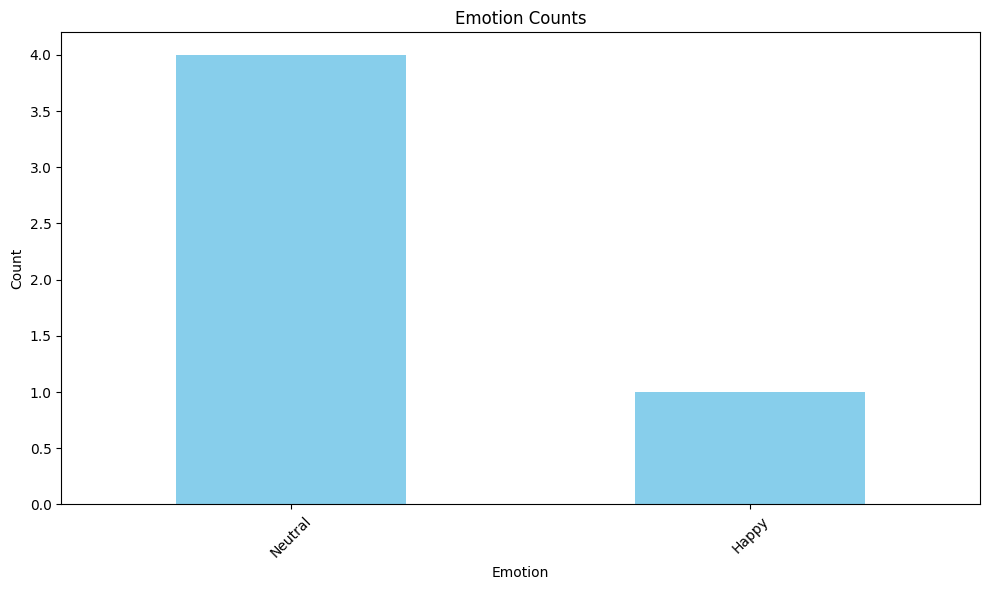

In [13]:
import matplotlib.pyplot as plt
df = pd.read_excel(excel_file)

# Generate a bar chart of emotion counts
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

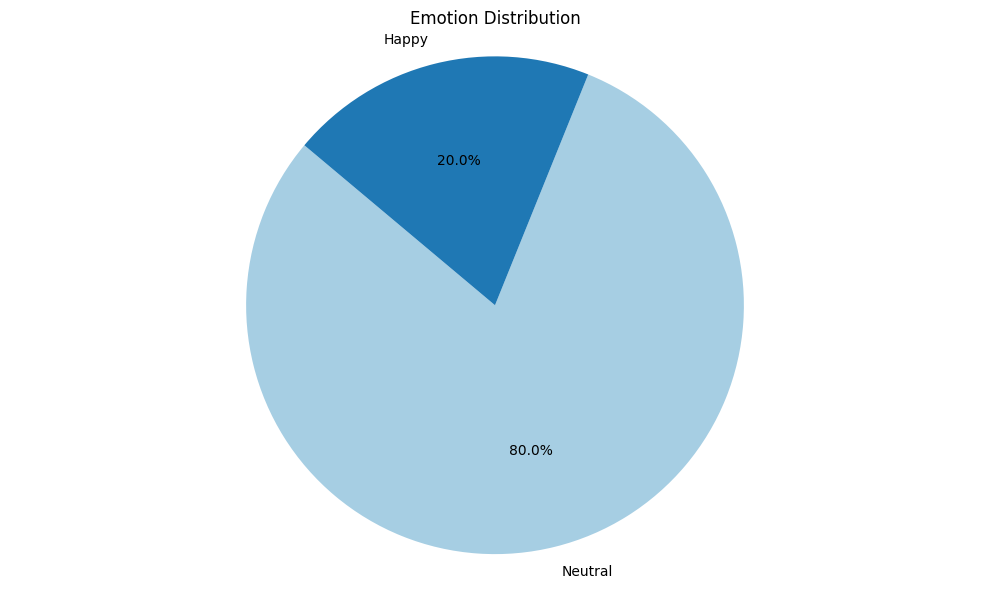

In [14]:
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(emotion_counts))))
plt.title('Emotion Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('emotion_distribution.png')
plt.show()

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Email notification function
def send_email_notification(emotion):
    # Your email and app password
    sender_email = "shreyubanawala@gmail.com"
    sender_password = "Shrey"
    recipient_email = "recipient_email@gmail.com"
    
    # Create message
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = "Emotion Detection Alert"
    body = f"Frequent detection of {emotion} emotion has been noticed."
    msg.attach(MIMEText(body, 'plain'))
    
    # Send email
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, sender_password)
        text = msg.as_string()
        server.sendmail(sender_email, recipient_email, text)
        server.quit()
        print("Email sent successfully")
    except Exception as e:
        print(f"Error: {str(e)}")

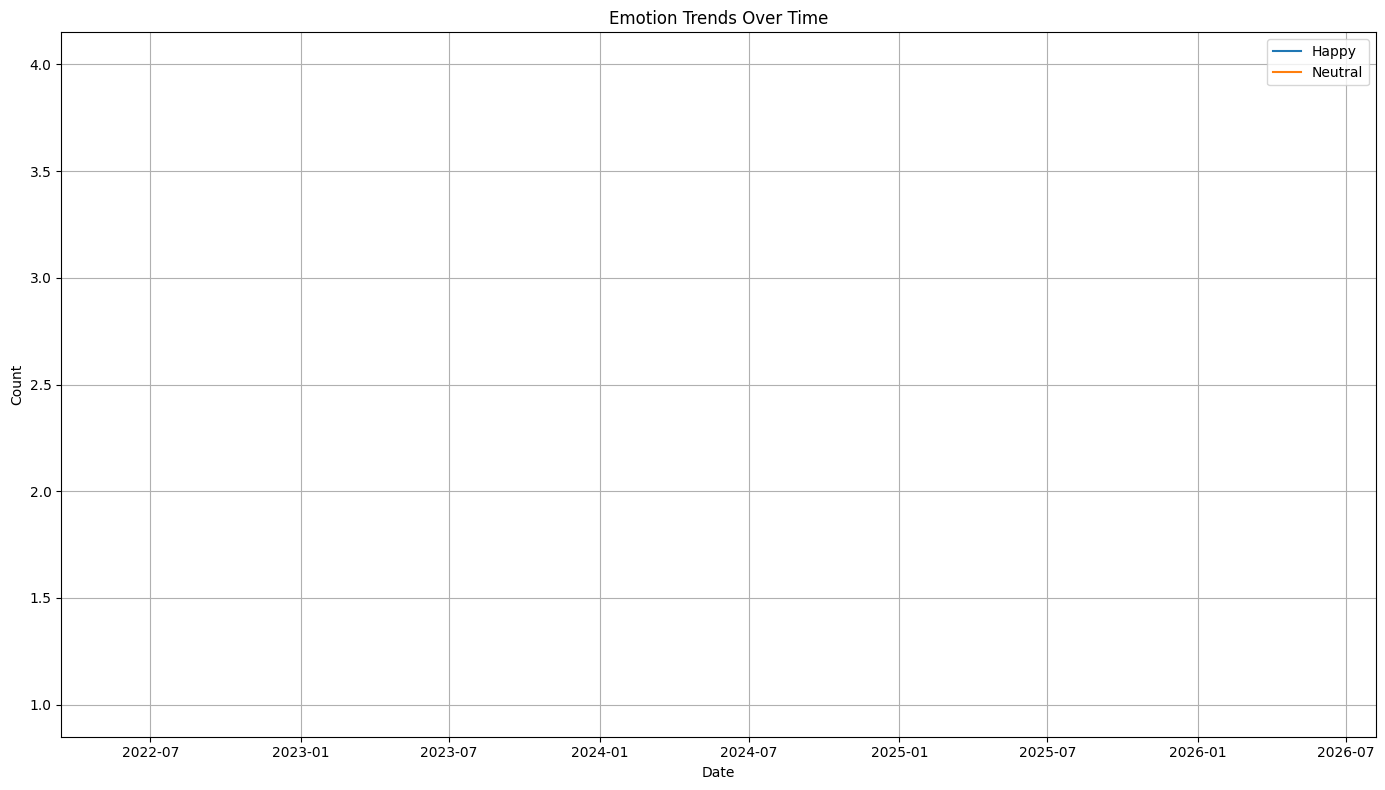

In [17]:
# Load data into a DataFrame
df = pd.read_excel(excel_file)

# Convert Date and Time to datetime object
df['Datetime'] = pd.to_datetime(df['Date'])

# Set Datetime as the index
df.set_index('Datetime', inplace=True)

# Resample the data by day and count each emotion
daily_emotion_counts = df.resample('D')['Emotion'].value_counts().unstack().fillna(0)

# Plot the trends
plt.figure(figsize=(14, 8))
for emotion in emotion_labels:
    if emotion in daily_emotion_counts:
        plt.plot(daily_emotion_counts.index, daily_emotion_counts[emotion], label=emotion)

plt.title('Emotion Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()